In [ ]:
!pip uninstall tensorflow
!pip install tensorflow===2.3.0

Found existing installation: tensorflow 2.3.0
Uninstalling tensorflow-2.3.0:


In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata14_20.csv')
table.head()

Date  IDStation  ... Wind_direction_max  Rainfall
0  2014-01-01T00:00:00Z        681  ...              143.0       0.0
1  2014-01-02T00:00:00Z        681  ...              153.0       7.8
2  2014-01-03T00:00:00Z        681  ...              152.0       0.0
3  2014-01-04T00:00:00Z        681  ...              164.0      35.8
4  2014-01-05T00:00:00Z        681  ...              136.0      25.0

[5 rows x 28 columns]

In [5]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index                  Date  PM10  ...  Wind_direction  Temperature  Rainfall
0      0  2014-01-01T00:00:00Z   6.0  ...            99.0    -0.334965       0.0
1      1  2014-01-02T00:00:00Z   6.0  ...           105.0    -0.486111       7.8
2      2  2014-01-03T00:00:00Z  11.0  ...           120.0     2.220588       0.0
3      3  2014-01-04T00:00:00Z   6.0  ...           175.0     2.137063      35.8
4      4  2014-01-05T00:00:00Z   3.0  ...            94.0     2.416084      25.0

[5 rows x 8 columns]

In [6]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [7]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [8]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  ...  var5(t-1)  var6(t-1)   var1(t)
5   0.066667        0.0   0.163005  ...   0.358295   0.112816  0.022222
6   0.066667        0.0   0.130139  ...   0.406390   0.000000  0.077778
7   0.122222        0.0   0.074531  ...   0.397825   0.000000  0.044444
8   0.066667        0.0   0.381024  ...   0.408315   0.000000  0.044444
9   0.033333        0.0   0.246694  ...   0.392536   0.000000  0.133333

[5 rows x 31 columns]

In [9]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 30) 1312 (1312,)
(1312, 5, 6) (1312,) (419, 5, 6) (419,)


# Modeling and training

Epoch 1/500
14/14 - 3s - loss: 0.1068 - val_loss: 0.0911
Epoch 2/500
14/14 - 0s - loss: 0.0941 - val_loss: 0.0862
Epoch 3/500
14/14 - 0s - loss: 0.0909 - val_loss: 0.0862
Epoch 4/500
14/14 - 0s - loss: 0.0904 - val_loss: 0.0856
Epoch 5/500
14/14 - 0s - loss: 0.0896 - val_loss: 0.0845
Epoch 6/500
14/14 - 0s - loss: 0.0889 - val_loss: 0.0852
Epoch 7/500
14/14 - 0s - loss: 0.0885 - val_loss: 0.0843
Epoch 8/500
14/14 - 0s - loss: 0.0884 - val_loss: 0.0859
Epoch 9/500
14/14 - 0s - loss: 0.0880 - val_loss: 0.0864
Epoch 10/500
14/14 - 0s - loss: 0.0875 - val_loss: 0.0854
Epoch 11/500
14/14 - 0s - loss: 0.0871 - val_loss: 0.0854
Epoch 12/500
14/14 - 0s - loss: 0.0866 - val_loss: 0.0848
Epoch 13/500
14/14 - 0s - loss: 0.0859 - val_loss: 0.0838
Epoch 14/500
14/14 - 0s - loss: 0.0853 - val_loss: 0.0833
Epoch 15/500
14/14 - 0s - loss: 0.0845 - val_loss: 0.0820
Epoch 16/500
14/14 - 0s - loss: 0.0834 - val_loss: 0.0800
Epoch 17/500
14/14 - 0s - loss: 0.0819 - val_loss: 0.0774
Epoch 18/500
14/14 - 0s

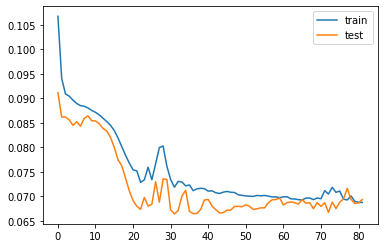

In [10]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

In [11]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.966


#### Prediciton plots

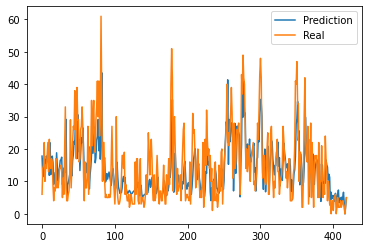

In [12]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

prediction with 2020

In [13]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!!
Moggio.head()
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 30) 1312 (1312,)
(1312, 5, 6) (1312,) (784, 5, 6) (784,)


In [14]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.380


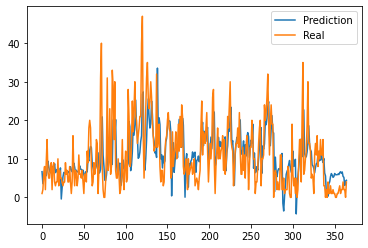

In [15]:
pyplot.plot(inv_yhat[-365:], label = 'Prediction')
pyplot.plot(inv_y[-365:], label = 'Real')
pyplot.legend()
pyplot.show()

# SHAP

In [16]:
!pip install shap